# Trying a Neural Network to predict the rest-eigen part from the eigenvalues and the eigen-eigen part

In [1]:
using LmaPredict, Flux, Statistics, ProgressMeter

## Reading the data

In [2]:
const path_config = "/Users/lukasgeyer/Studium/Computational Sciences/Masterarbeit/Daten Simon/dat"
const path_plot = "../plots"

"../plots"

In [3]:
fname = readdir(path_config)[2:5001]
idx = sortperm( parse.(Int64, fname))
fname = fname[idx]

cnfgarr = Vector{LMAConfig}(undef, 0)
for f in fname
    push!(cnfgarr, get_LMAConfig(joinpath(path_config, f), "g5-g5", em="PA", bc=false))
end

## Splitting data in training and test sets

In [4]:
# Select a specific Tsource and divide data into training and test set for eigenvalues, rr re and ee components
TSRC="12"
NCNFG = length(cnfgarr)
TVALS = length(cnfgarr[1].data["rr"][TSRC]) -1
EIGVALS = minimum(length.([cnfgarr[i].data["eigvals"] for i in 1:NCNFG]))

eigvals_data = Array{Float32}(undef, EIGVALS, 4500)
rr_data = Array{Float32}(undef, TVALS, 4500)
ee_data = Array{Float32}(undef, TVALS, 4500)
re_data = Array{Float32}(undef, TVALS, 4500)

eigvals_data_test = Array{Float32}(undef, EIGVALS, 500)
rr_data_test = Array{Float32}(undef, TVALS, 500)
ee_data_test = Array{Float32}(undef, TVALS, 500)
re_data_test = Array{Float32}(undef, TVALS, 500)

for (k, dd) in enumerate(getfield.(cnfgarr, :data)[1:4500])
    eigvals_data[:,k] = copy(cnfgarr[k].data["eigvals"][1:EIGVALS])
    rr_data[:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data[:,k] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data[:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
end
for (k, dd) in enumerate(getfield.(cnfgarr, :data)[4501:5000])
    eigvals_data_test[:,k] = copy(cnfgarr[k].data["eigvals"][1:EIGVALS])
    rr_data_test[:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data_test[:,k] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data_test[:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
end

## Describing the Neural Network

As input we choose a vector containing the inverted eigenvalues $\{\lambda_i\}$ as the first $n_{\lambda}$ entries, followed by the eigen-eigen contributions $\{ee_i\}$:



$v_{input} = \begin{bmatrix} \ \frac{1}{\lambda_1} \ \\[6pt] \ \frac{1}{\lambda_2} \ \\[6pt] \ \frac{1}{\lambda_3} \ \\[6pt] \vdots \\[6pt] \frac{1}{\lambda_{n_{\lambda}}} \\[6pt]
 \ ee_1 \ \\[6pt] \ ee_2 \ \\[6pt]\ ee_3 \ \\[6pt] \vdots \\[6pt]\ ee_{n_{ee}} \ \end{bmatrix}$

 where $n_{ee}$ is the number of time samples, 47 in our case. $\\[10pt]$

Our Neural Network therefore has an input layer of size $n_{\lambda} + n_{ee}$. We then try one fully connected layer of size $2(n_{\lambda} + n_{ee})$ and a fully connected output layer of size $n_{ee}$. 

**Note:** As we do not have the same amount of eigenvalues available for each configuration, we calculate the minimum of available eigenvalues out of all configurations, such that we can use as many as possible.

**Note:** Notice the shift introduced. The rest-eigen contributions seem to be normalized when values are shifted by this factor. This helps if we introduce the softmax function in the last step of the model which normalizes the output.

mean: 1.0000997792815716
std: 0.002564724621740984
variance: 6.577812385364434e-6


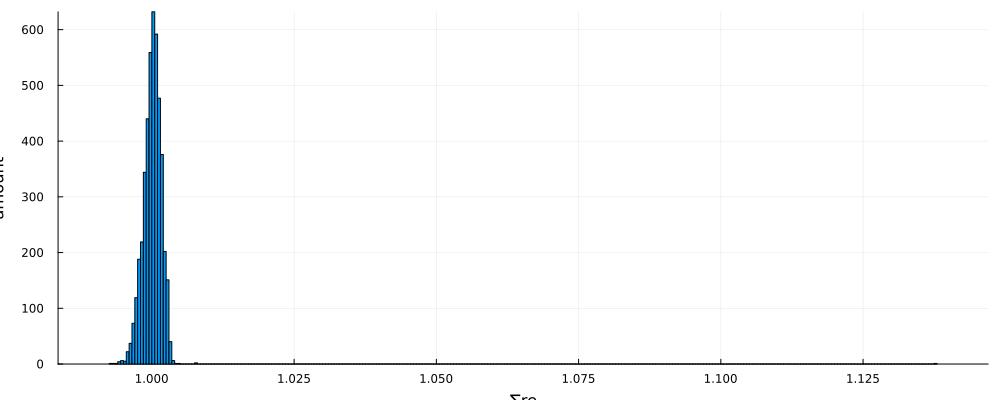

In [39]:
using Plots

shift = 0.021491

shifted_re = re_data .+ shift
summed_shifted_re = [sum(re_data[:,i] .+ shift) for i in 1:4500]

println("mean: ", mean(summed_shifted_re))
println("std: ", std(summed_shifted_re))
println("variance: ", var(summed_shifted_re))

histogram(summed_shifted_re, size=(1000,400),legend=:false)
xlabel!("∑re")
ylabel!("amount")

In [133]:
input_length = TVALS + EIGVALS
output_length = TVALS
hidden_length = 2*input_length

input_data = vcat(1 ./ eigvals_data, ee_data)
target = re_data .+ shift

test_input_data = vcat(1 ./ eigvals_data_test, ee_data_test)
test_target = re_data_test .+ shift;

## Defining the Network

In [134]:
model = Chain(
    Dense(input_length => hidden_length, tanh),
    BatchNorm(hidden_length),
    Dense(hidden_length => output_length, tanh),
    softmax
    ) 

Chain(
  Dense(111 => 222, tanh),              # 24_864 parameters
  BatchNorm(222),                       # 444 parameters, plus 444
  Dense(222 => 47, tanh),               # 10_481 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 35_789 parameters,
          # plus 2 non-trainable, 444 parameters, summarysize 142.012 KiB.

## Defining training input and target data

In [135]:
loader = Flux.DataLoader((input_data, target), batchsize=32, shuffle=true)

optim = Flux.setup(Flux.Adam(0.0001), model);

## Training the Network

The network sees the whole data set **epochs** times. As loss function we use Mean Absolute Error.

In [136]:
epochs = 1_000

losses = []
@showprogress for epoch in 1:epochs
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            y_hat = m(x)
            Flux.mse(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss) 
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


## Checking loss dynamics during training

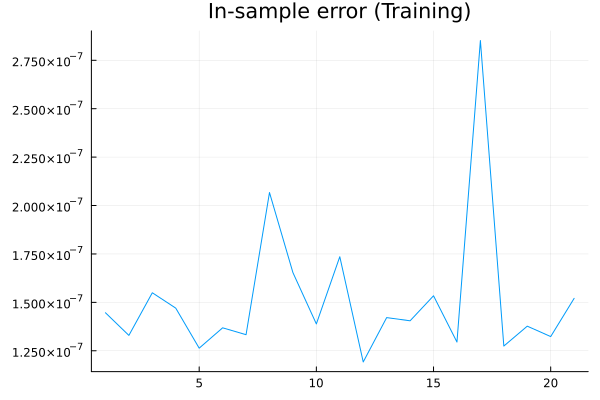

In [137]:
using Plots

plot(losses[end-20:end], title="In-sample error (Training)", legend=:false)

## Checking out-of-sample results

In [138]:
out_of_sample_predictions = model(test_input_data);

maximum error: 2.63498579576837e-6
minimum error: 2.5436726828465092e-8
average error: 3.867620576393696e-7


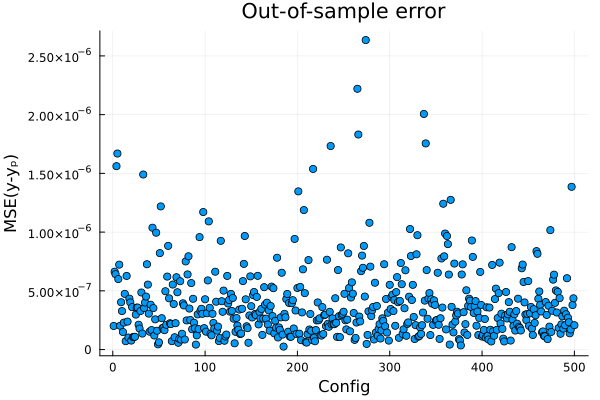

In [139]:
out_of_sample_error = [Flux.mse(out_of_sample_predictions[:,i], test_target[:,i]) for i in 1:500]

println("maximum error: ", maximum(out_of_sample_error))
println("minimum error: ", minimum(out_of_sample_error))
println("average error: ", mean(out_of_sample_error))

scatter(out_of_sample_error, title="Out-of-sample error", legend=:false)

xlabel!("Config")
ylabel!("MSE(y-yₚ)")

Current best perfomance:

maximum error: 1.4382569458100352e-6

minimum error: 2.3611581318928464e-8

average error: 2.9356580255092587e-7

with this model:

model = Chain(
    Dense(input_length => hidden_length, tanh),
    BatchNorm(hidden_length),
    Dense(hidden_length => output_length, tanh),
    softmax
    ) 

In [140]:
using Plots

l = @layout [a b c; d e f; g h i]

c1 = rand([i for i in 1:500])
p1 = scatter(test_target[:,c1], label="Actual")
scatter!(p1, out_of_sample_predictions[:,c1], label="Prediction", legend=:top)

c2 = rand([i for i in 1:500])
p2 = scatter(test_target[:,c2], label="Actual")
scatter!(p2, out_of_sample_predictions[:,c2], label="Prediction", legend=:top)

c3 = rand([i for i in 1:500])
p3 = scatter(test_target[:,c3], label="Actual")
scatter!(p3, out_of_sample_predictions[:,c3], label="Prediction", legend=:top, )

c4 = rand([i for i in 1:500])
p4 = scatter(test_target[:,c4], label="Actual")
scatter!(p4, out_of_sample_predictions[:,c4], label="Prediction", legend=:top)

c5 = rand([i for i in 1:500])
p5 = scatter(test_target[:,c5], label="Actual")
scatter!(p5, out_of_sample_predictions[:,c5], label="Prediction", legend=:top)

c6 = rand([i for i in 1:500])
p6 = scatter(test_target[:,c6], label="Actual")
scatter!(p6, out_of_sample_predictions[:,c6], label="Prediction", legend=:top)

c7 = rand([i for i in 1:500])
p7 = scatter(test_target[:,c7], label="Actual")
scatter!(p7, out_of_sample_predictions[:,c7], label="Prediction", legend=:top)

c8 = rand([i for i in 1:500])
p8 = scatter(test_target[:,c8], label="Actual")
scatter!(p8, out_of_sample_predictions[:,c8], label="Prediction", legend=:top)

c9 = rand([i for i in 1:500])
p9 = scatter(test_target[:,c9], label="Actual")
scatter!(p9, out_of_sample_predictions[:,c9], label="Prediction", legend=:top)

plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, layout = l, size=(1200,1000), dpi=1000, markerstrokewidth = 0)
#savefig(joinpath(path_plot, "neural_network_test.pdf"))